## This file is to read the loss.npz
```
In the .npz file, it have the different data.files
```
| __.npz__ named（） | type | shape |
|-------|-------|-------|
| loss | list | 单元3 |
| recon_loss | list | 单元6 |
| latent loss | list | 单元6 |
| mse_loss(the same as recon_loss) | list | 单元6 |

In [2]:
import numpy as np
import matplotlib.pyplot as plt
data = np.load('npz')


for key in data.files:
    print(key)


FileNotFoundError: [Errno 2] No such file or directory: 'npz'

In [15]:
print(data.files)



['loss', 'recon_loss', 'mse']


## This is for the loss plot
```bash
python .git
```

Text(0.5, 1.0, 'plot loss')

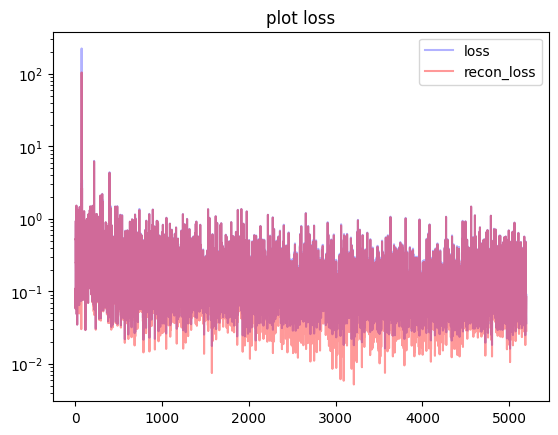

In [35]:
array1 = data['loss']
recon_loss = data['recon_loss']
mse_loss= data['mse'] 
#discount=0 mean that mse =recon_loss
plt.plot(array1,color='blue',alpha=0.3,label='loss')
plt.plot(recon_loss,color='red',alpha=0.4,label='recon_loss')

plt.legend()
plt.yscale('log')
plt.title("plot loss")